<a href="https://colab.research.google.com/github/jsilryan/Algorithms/blob/master/Document_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qqq selenium --progress-bar off
!pip install -qqq Selenium-Screenshot --progress-bar off
!pip install -qqq transformers --progress-bar off
!pip install -qqq pytorch-lightning --progress-bar off
!pip install -qqq pytesseract --progress-bar off
!pip install -qqq Pillow --progress-bar off

  Preparing metadata (setup.py) ... done


- Selenium - browser automation library
- Screenshot - converts html to image
- transformers - training
- pytesseract - python bindings for OCR on the images
- Pillow
- Chromium - Selenium drover for Chrome
- Tesseract OCR - binary of the OCR engine

In [2]:
!apt-get -qq update > /dev/null
!apt -qq install chromium-chromedriver > /dev/null
!apt -qq install tesseract-ocr > /dev/null

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)






In [3]:
!apt-get update
!apt-get install -y chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

In [4]:
import os

file_path = "archive.zip"
file_id = "1f1cJGYQ7J0XnDLba7j-km96fB2dhW3Zy"

if os.path.isfile(file_path):
    print(f"{file_path} already exists.")
else:
    !gdown {file_id} -O {file_path} --no-cookies


Downloading...
From: https://drive.google.com/uc?id=1f1cJGYQ7J0XnDLba7j-km96fB2dhW3Zy
To: /content/archive.zip
100% 3.10M/3.10M [00:00<00:00, 45.2MB/s]


In [5]:
extracted_folder = "TableClassifierQuaterlyWithNotes"
target_folder = "Docs"

# Check if the target folder already exists
if os.path.isdir(target_folder):
    print(f"{target_folder} already exists.")
else:
    # Unzip the archive
    !unzip -q {file_path}

    # Rename the extracted folder to the target folder name
    if os.path.isdir(extracted_folder):
        !mv {extracted_folder} {target_folder}
    else:
        print(f"Error: Expected folder '{extracted_folder}' not found after unzipping.")

In [6]:
!ls

archive.zip  Docs  sample_data


In [7]:
!pip install Screenshot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 50.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [8]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification # SequenceClassification is the model itself
from selenium import webdriver
from Screenshot import Screenshot
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np

import sys
from pathlib import Path
from PIL import Image
import io

# Install into the System Path
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')

In [9]:
list(Path("Docs").glob("*"))

[PosixPath('Docs/Cash Flow'),
 PosixPath('Docs/Notes'),
 PosixPath('Docs/Income Statement'),
 PosixPath('Docs/Balance Sheets'),
 PosixPath('Docs/Others')]

In [10]:
# Path to the Docs directory
docs_path = Path("Docs")

# Iterate through items in the Docs directory
for dir in docs_path.glob("*"):
    if dir.is_dir() or dir.is_file():  # Ensure the item is a file or directory
        new_name = dir.name.lower().replace(" ", "_")
        new_path = docs_path / new_name

        # Check if the new path already exists to avoid conflicts
        if dir != new_path and not new_path.exists():
            try:
                dir.rename(new_path)
            except FileNotFoundError as e:
                print(f"Error renaming {dir} to {new_path}: {e}")

# List the contents of the Docs directory
list(docs_path.glob("*"))

[PosixPath('Docs/balance_sheets'),
 PosixPath('Docs/cash_flow'),
 PosixPath('Docs/income_statement'),
 PosixPath('Docs/others'),
 PosixPath('Docs/notes')]

### Create images based on the HTML docs

In [11]:
for dir in docs_path.glob("*"):
  image_dir = Path(f"images/{dir.name}")
  image_dir.mkdir(exist_ok = True, parents = True)

list(Path("images").glob("*"))

[PosixPath('images/balance_sheets'),
 PosixPath('images/cash_flow'),
 PosixPath('images/income_statement'),
 PosixPath('images/others'),
 PosixPath('images/notes')]

In [12]:
!pip install webdriver-manager --quiet

In [13]:
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

def create_chrome_driver() -> webdriver.Chrome:
  chrome_options = webdriver.ChromeOptions()

  # Using an Ubuntu server behind Colab
  chrome_options.add_argument("--headless")
  chrome_options.add_argument("--no-sandbox")
  chrome_options.add_argument("--disable-dev-shm-usage")

  return webdriver.Chrome(options=chrome_options)

In [14]:
driver =  create_chrome_driver()
driver

<selenium.webdriver.chrome.webdriver.WebDriver (session="21ad06a6eff4fdc31a3c676d27c6468f")>

In [15]:
def convert_html_to_image(
    driver: webdriver.Chrome,
    file_path: Path,
    images_dir: Path
) -> Path:
  driver.get(f"file:///content/{str(file_path)}")
  # Take screenshot
  screenshot = driver.get_screenshot_as_png()

  # Save screenshot to file
  image = Image.open(io.BytesIO(screenshot))

  image_name = file_path.with_suffix(".png").name  # Replace '.html' with '.png'
  image_path = images_dir / file_path.parent.name / image_name  # Use Path methods
  image.save(image_path)

  return image_path

In [16]:
document_paths = list(Path("Docs").glob("*/*"))[:10]
print(document_paths)
for doc_path in tqdm(document_paths):
  convert_html_to_image(driver, doc_path, Path("images"))

[PosixPath('Docs/balance_sheets/18679721_3.html'), PosixPath('Docs/balance_sheets/18837492_3.html'), PosixPath('Docs/balance_sheets/18671329_6.html'), PosixPath('Docs/balance_sheets/18808741_3.html'), PosixPath('Docs/balance_sheets/18666982_12.html'), PosixPath('Docs/balance_sheets/18628415_7.html'), PosixPath('Docs/balance_sheets/18506923_4.html'), PosixPath('Docs/balance_sheets/18666988_4.html'), PosixPath('Docs/balance_sheets/18628294_4.html'), PosixPath('Docs/balance_sheets/18889483_2.html')]


100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Images directly inside "images":
- image_paths = list(Path("images").glob("*"))

Images in SubDirectories in Images:
- image_paths = list(Path("images").glob("*/**"))

Include files in subdirectories:
- image_paths = list(Path("images").rglob("*"))


In [17]:
image_paths = list(Path("images").glob("*/*"))
image_paths

[PosixPath('images/balance_sheets/18837492_3.png'),
 PosixPath('images/balance_sheets/18506923_4.png'),
 PosixPath('images/balance_sheets/18671329_6.png'),
 PosixPath('images/balance_sheets/18889483_2.png'),
 PosixPath('images/balance_sheets/18628415_7.png'),
 PosixPath('images/balance_sheets/18808741_3.png'),
 PosixPath('images/balance_sheets/18628294_4.png'),
 PosixPath('images/balance_sheets/18679721_3.png'),
 PosixPath('images/balance_sheets/18666982_12.png'),
 PosixPath('images/balance_sheets/18666988_4.png')]

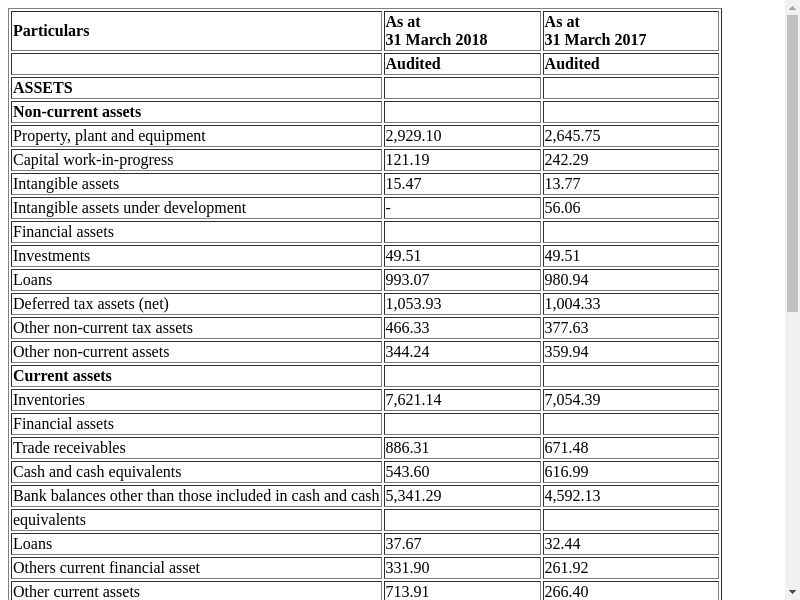

In [46]:
image = Image.open(image_paths[0]).convert('RGB')
image

### Get Feature Extractor

In [22]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=True, ocr_lang="eng")
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [23]:
encoding = processor(
    image,
    max_length = 512,
    padding = "max_length",
    truncation = True,
    return_tensors = "pt" # Pytorch format
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

Input_ids - tokenized words (max length passed in)

Bbox - for bounding box of the words
-> max_length, sides (left, right, top, bottom)

Image_data - 3, 224, 224 - RGB (3 color channels), width, height - which converts it from an image with different sizes to a standard size

Pixel_values - for image embedding

In [24]:
print(f"""
input_ids: {list(encoding["input_ids"].squeeze().shape)}
word_boxes: {list(encoding["bbox"].squeeze().shape)}
image_data: {list(encoding["pixel_values"].squeeze().shape)}
image_size: {image.size}
""")


input_ids: [512]
word_boxes: [512, 4]
image_data: [3, 224, 224]
image_size: (800, 600)



In [25]:
feature_extractor

# image_mean and image_std are used for normalization

LayoutLMv3FeatureExtractor {
  "apply_ocr": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "LayoutLMv3FeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": "eng",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

In [27]:
features = feature_extractor(image)
features.keys()
# Word boxes must be the same as word count

dict_keys(['pixel_values', 'words', 'boxes'])

In [28]:
print(f"""
image size: {features["pixel_values"][0].shape}
Word Count: {len(features["words"][0])}
Word Boxes: {len(features["boxes"][0])}
""")


image size: (3, 224, 224)
Word Count: 100
Word Boxes: 100



In [30]:
# Bounding box example
features["boxes"][0][0]

[3, 33, 110, 91]

In [31]:
image_data = features["pixel_values"][0]
image_data.shape

(3, 224, 224)

In [32]:
# Swap color channel to the rightmost side
image_data = image_data.transpose(1, 2, 0)
image_data.shape

(224, 224, 3)

In [34]:
# They are floats - convert to unsigned integer of 8 bit precision
image_data[0][0]

array([1., 1., 1.], dtype=float32)

In [36]:
image_data = np.uint8(image_data * 255) # multiply image data by 255
image_data[0][0]

array([255, 255, 255], dtype=uint8)

Image fed into the model

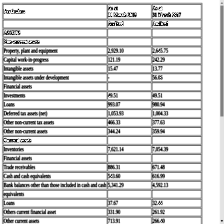

In [38]:
Image.fromarray(image_data, mode = "RGB")

Words and Bounding Boxes

In [43]:
features["words"]

[['[Particulars',
  'BY',
  'March',
  '2018',
  'Bt',
  'March',
  '2017',
  '[Audited',
  '[Audited',
  '[ASSETS',
  '|Non-current',
  'assets',
  '(Property,',
  'plant',
  'and',
  'equipment',
  '2,929.10',
  '2,645.75',
  '[Capital',
  'work-in-progress',
  '[121.19',
  '[242.29',
  '[intangible',
  'assets',
  '[15.47',
  '[13.77',
  '[intangible',
  'assets',
  'under',
  'development',
  'E',
  '[56.06',
  '[Financial',
  'assets',
  '[investments',
  '[49.51',
  '[49.51',
  '[Loans',
  '[993.07',
  '(080.94',
  '[Deferred',
  'tax',
  'assets',
  '(net)',
  '1,053.93,',
  'f,004.33,',
  '[Other',
  'non-current',
  'tax',
  'assets',
  '[466.33',
  '77.63',
  '[Other',
  'non-current',
  'assets,',
  '[p44.24',
  '[359.94',
  '|Current',
  'assets',
  '[inventories',
  '[7,621.14',
  '[7,054.39',
  '[Financial',
  'assets',
  '[Trade',
  'receivables',
  '[p86.31',
  '[o71.48',
  '[Cash',
  'and',
  'cash',
  'equivalents',
  '[543.60',
  '[616.99',
  '[Bank',
  'balances',
 

In [44]:
words = features["words"][0]
bounding_boxes = features["boxes"][0]

print(words[:5])
print(bounding_boxes[:5])

['[Particulars', 'BY', 'March', '2018', 'Bt']
[[3, 33, 110, 91], [458, 20, 500, 91], [507, 20, 563, 91], [557, 40, 608, 91], [666, 20, 702, 91]]


#### Draw bounding boxes on text

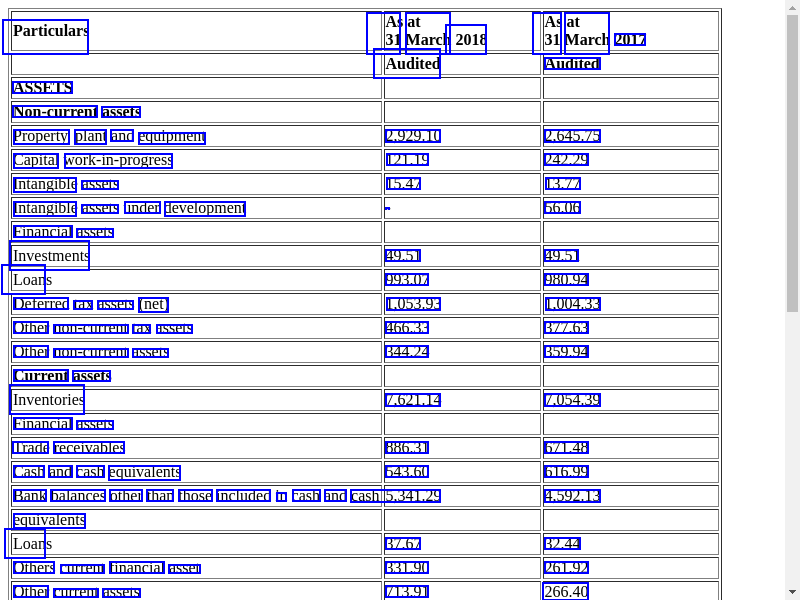

In [48]:
image = Image.open(image_paths[0]).convert('RGB')

width_scale = image.width / 1000
height_scale = image.height / 1000

draw = ImageDraw.Draw(image)

for bbox in bounding_boxes:
  draw.rectangle(
    [
      bbox[0] * width_scale,
      bbox[1] * height_scale,
      bbox[2] * width_scale,
      bbox[3] * height_scale
    ],
    outline = "blue",
    width = 2
  )

image

In [49]:
tokenizer

LayoutLMv3TokenizerFast(name_or_path='microsoft/layoutlmv3-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

In [50]:
encoding = tokenizer(
    text=words,
    boxes=bounding_boxes,
    max_length=512,
    truncation=True,
    return_tensors="pt"
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox'])

In [51]:
tokens = tokenizer.convert_ids_to_tokens(
    encoding["input_ids"][0],
    skip_special_tokens = True
)

print(tokens[:20])

['Ġ[', 'Part', 'icular', 's', 'ĠBY', 'ĠMarch', 'Ġ2018', 'ĠB', 't', 'ĠMarch', 'Ġ2017', 'Ġ[', 'Aud', 'ited', 'Ġ[', 'Aud', 'ited', 'Ġ[', 'ASS', 'ETS']


In [52]:
tokenizer.convert_tokens_to_string(tokens[:20])

' [Particulars BY March 2018 Bt March 2017 [Audited [Audited [ASSETS'

In [53]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("microsoft/layoutlmv3-base")
model.config

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv3Config {
  "_name_or_path": "microsoft/layoutlmv3-base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 514,
  "max_rel_2d_pos": 256,
  "max_rel_pos": 128,
  "model_type": "layoutlmv3",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "patch_size": 16,
  "rel_2d_pos_bins": 64,
  "rel_pos_bins": 32,
  "second_input_size": 112,
  "shape_size": 128,
  "text_embed": true,
  "torch_dtype": "float32",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "visual_embed": true,
  "vocab_size": 50265
}

In [54]:
encoding = processor(
    image,
    max_length = 512,
    padding = "max_length",
    truncation = True,
    return_tensors = "pt"
)

outputs = model(**encoding)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1060: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [55]:
outputs.logits

tensor([[-0.1025, -0.0123]], grad_fn=<AddmmBackward0>)